# Bayesian Nonparametric Regression Discontinuity Design

Table of contents:
* Very brief overview of RDD
* Bayesian Nonparametric interpretation of RDD
* Simulation demo
* Empirical demo

## Very brief overview of RDD

Regression Discontinuity Design (RDD) is a method used for establishing the causal effect of an intervention that is based on a thresholded predictor. As a simple example, let $x_i$ be the cholesterol level of patient $i$, and let $y_i$ be the same persons cholesterol one month later. We decide to treat $i$ if their cholesterol exceeds a certain threshold, i.e. iff $x_i > T$. If the treatment has an effect, the observed $y_i$ that correspond to post-threshold patients is lower than if the pre-treatment trend would continue uninterrupted. This deviation from the expected trend is referred to as a discontinuity. It is typically identified by applying linear regression to the data pre-threshold and post-threshold separately, and comparing the predictions of these two models at $T$.

RDD works by assuming that around the threshold, patients are roughly randomly distributed, so that we effectively have a randomized controlled trial around $T$. Importantly, this presupposestthat participants do not actively control whether they are below or above threshold; otherwise there is no randomization.

## Bayesian Nonparametric interpretation of RDD

There are two main limitations to this classical RDD approach (note that several improvements on RDD already exist). First of all the linearity assumption grealy limits the expressiveness of the model. Nonlinear interactions cannot be accounted for, or the data need to be substantially preprocessed before RDD can be applied. Here, we provide a generic solution that can describe infinite possible interactions.

Second, the standard RDD approach is implemented in the frequentist statistics framework and bases its conclusions on $p$-values. This has the downside of not being able to provide evidence in favor of the null model, i.e. the absence of an effect. As the name implies, BNP-RDD is a Bayesian approach which uses Bayesian model comparison (one model representing a discontinuity, one model being continuous). This way, it can also provide evidence in favor of the absence of a discontinuity. Furthermore, it allows for Bayesian model averaging, which provides estimates&predictions based on both models. The latter is particularly relevant if the comparison is not decisive.

### Gaussian process regression and model comparison

Rather than fitting a linear regression model $y_i = f(x_i)+\epsilon$, with $f(x_i)=ax_i + b$, to the pre- and post threshold data, our approach proceeds as follows. 

1. We place a Gaussian process (GP) _prior_ on $f$. In a GP, we do not specify the functional form of a function (i.e. linear, quadratic, periodic, etc.), but we specify a _kernel_ that indicates how similar the responses $y_i$ and $y_j$ are depending on the distance between $x_i$ and $x_j$ (note that using the appropriate specification, we simply obtain the linear model again; linear regression is a special case of GP regression. Similarly, if we provide a _constant_ kernel, we have a very convoluted way of performing a t-test). 
2. We learn $f$ pre- and post threshold for the discontinuous model $M_D$. Next, we learn $f$ on the whole data set as if there was no threshold at all, representing a continuous model $M_C$.
3. We compute the _Bayes factor_ $$BF_{DC} = p(x,y \mid M_D) / p(x,y\mid M_C)\enspace.$$ This has an intuitive interpretation. For instance $BF_{DC}= 0.1$ simply means the data are 10 times _less_ likely if we assume a discontinuous model.

The flexibility of this approach comes from the unlimited amount of different kernels that can be constructed, enabling many different (nonlinear) interactions to be modelled. 

## Demo on simulated data

Let's see some BNP-RDD in action. First we generate some random data:

In [16]:
def generate_data_1D(labelFunc, n=10, snr=1.0):    
    xmin    = -1.5
    xmax    = 1.5
    x       = np.linspace(xmin, xmax, num=n)    
    noise   = np.random.normal(size=n)    
    gap     = snr
    
    b0, b1, b2 = (5, 1.2, 0.0)
    y = b0 + b1*x + b2*np.sin(x) + noise
    
    labels = labelFunc(x)
    y[labels] += gap
    
    return x, y, labels
#

labelFunc = lambda x: x > 0
x, y, _ = generate_data_1D(labelFunc, n=25, snr=3.0)   

Let's run BNP-RDD for two different kernels, a linear one and the Matern 3/2 one (see [here](https://www.cs.toronto.edu/~duvenaud/cookbook/) for more on GP kernels). The results are provided as plots here.

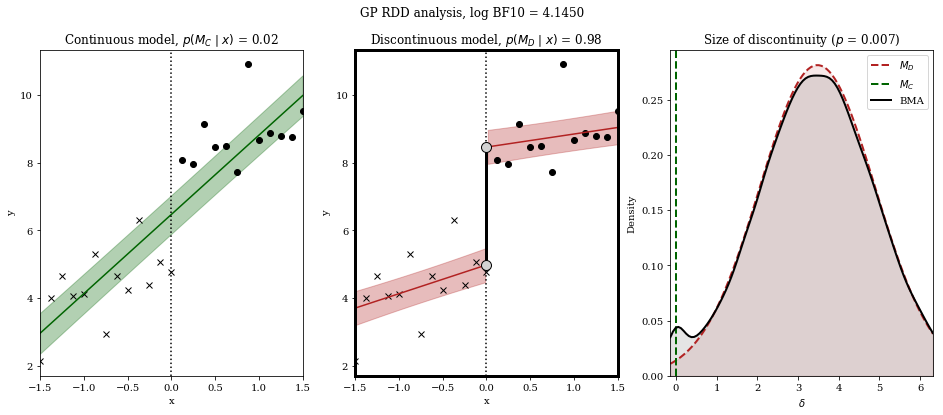

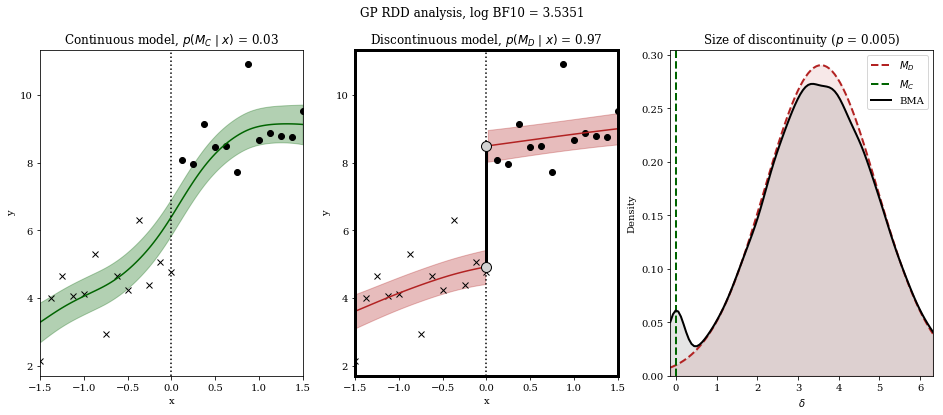

In [17]:
x_test = np.linspace(-1.5, 1.5, num=100)  
for kerneltype in ['Linear', 'Matern32']:
    kernel = GPRDDAnalysis.get_kernel(kerneltype=kerneltype, D=1)
    gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel, labelFunc)
    gprdd.train()    
    _ = gprdd.plot(x_test, plotEffectSize=True)

## Demo on empirical data

## Sicily Smoking Ban Data

A study by [Barone-Adesi et al., 2011](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0017419). The predictor variable here is time, with the intervention (the smoking ban) occurring on January, 2005. The response variable is the rate of acute coronary events (ACEs) per age-standardized population.

In [18]:
import csv
import scipy.stats as stats
import warnings; warnings.simplefilter('ignore')

datafile = 'datasets\\sicilysmokingban\\sicily.csv'
data = dict()

with open(datafile, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for k, v in dict(row).items():
            if k in data:
                data[k].append(v)
            else:
                data[k] = [v]

data['year']    = np.array([int(y) for y in data['year']])
data['month']   = np.array([int(m) for m in data['month']])
data['aces']    = np.array([int(a) for a in data['aces']]) # acute coronary events
data['time']    = np.array([int(t) for t in data['time']]) # predictor
data['smokban'] = np.array([s=='1' for s in data['smokban']])
data['pop']     = np.array([float(t) for t in data['pop']])
data['stdpop']  = np.array([float(st) for st in data['stdpop']]) # age-standardized population numbers

# Some transformations, needed to keep kernel matrices positive definite with reasonable parameter estimates.
# We simply transform back and forth when necessary.
zscorex = lambda x: (x - np.mean(data['time'])) / np.std(data['time'])
zscorey = lambda x: (x - np.mean(aces_per_agestd_pop)) / np.std(aces_per_agestd_pop)
inv_zscorey = lambda z: z*np.std(aces_per_agestd_pop) + np.mean(aces_per_agestd_pop)

n = len(data['time'])
b = data['time'][data['smokban']][0] - 1 # the ban instantiated *before* this
bz = zscorex(b)

labelFunc = lambda x: x > bz

aces_per_agestd_pop = data['aces'] / data['stdpop']*10**5

x = zscorex(data['time'])
y = stats.zscore(aces_per_agestd_pop) # ACE / age-standardized population
D = 1 # this is a 1D time-series

We construct a number of kernels to use:

In [19]:
linear_kernel = GPy.kern.Linear(D) + GPy.kern.Bias(D)
periodic_kernel = GPy.kern.StdPeriodic(D, period=12) + GPy.kern.Linear(D)
_ = periodic_kernel['std_periodic.period'].constrain_fixed()
brownian_kernel = GPy.kern.Brownian(D)
matern32_kernel = GPy.kern.Matern32(D)

We train and plot results for all kernels:

Training model with Linear kernel
ACE risk reduction according to discontinuous model: 4.9%
ACE risk reduction according to BMA: 2.0%
Bayes factor in favor of a discontinuity: 0.6893

Training model with Periodic kernel
ACE risk reduction according to discontinuous model: 5.7%
ACE risk reduction according to BMA: 2.0%
Bayes factor in favor of a discontinuity: 0.5584

Training model with Brownian kernel
ACE risk reduction according to discontinuous model: 6.6%
ACE risk reduction according to BMA: 2.3%
Bayes factor in favor of a discontinuity: 0.5176

Training model with Matern32 kernel
ACE risk reduction according to discontinuous model: 5.5%
ACE risk reduction according to BMA: 1.6%
Bayes factor in favor of a discontinuity: 0.4245



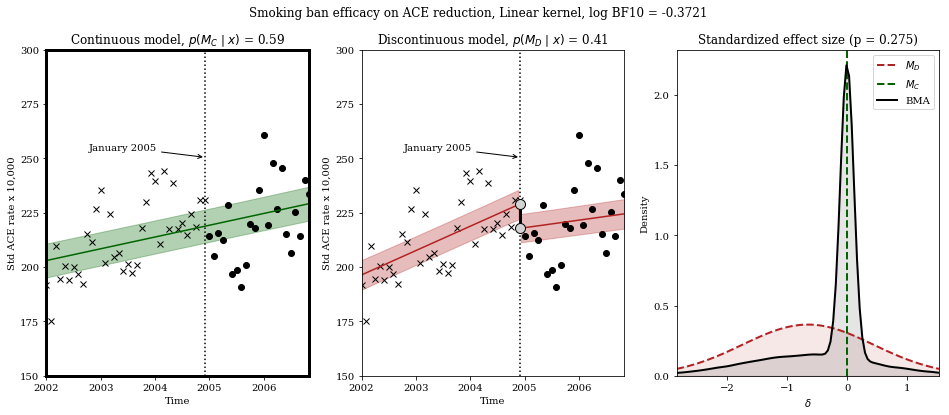

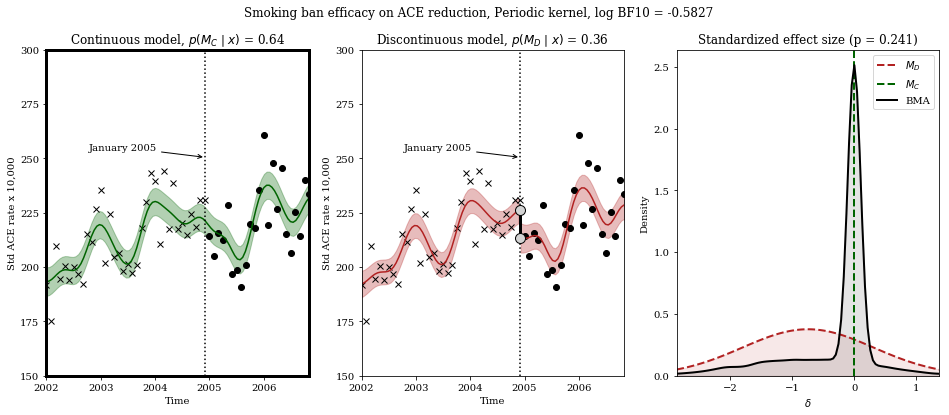

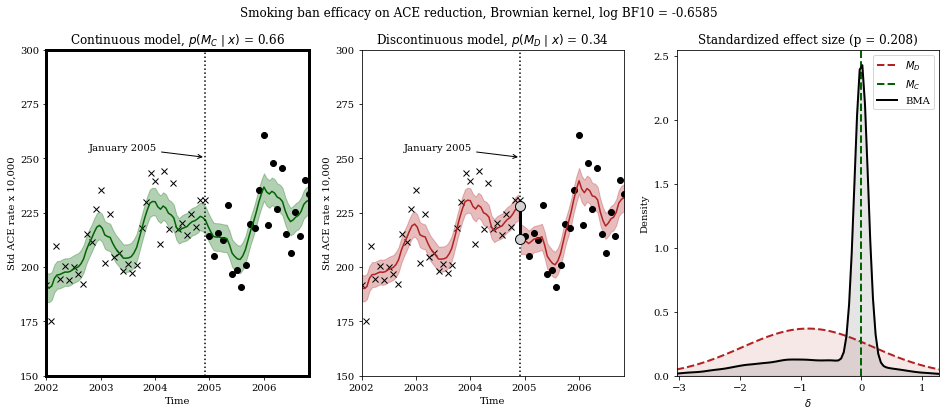

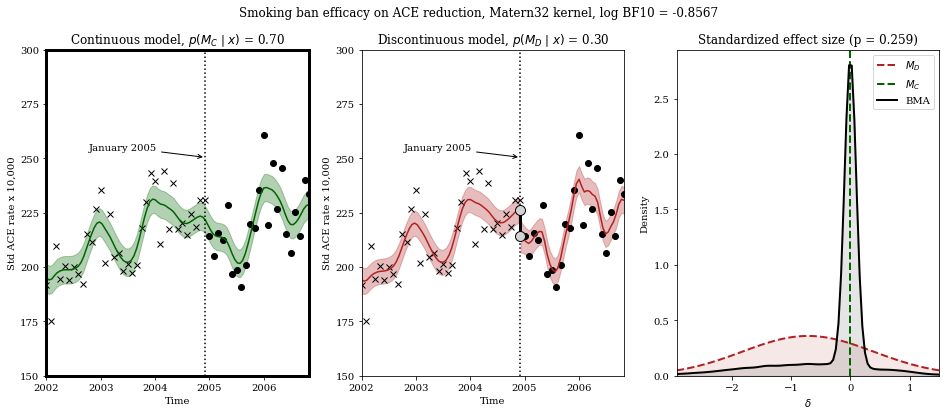

In [20]:
x_test = np.linspace(x[0], x[-1], num=100)  # interpolate between actual observations
num_restarts = 50
kernel_names = ['Linear', 'Periodic', 'Brownian', 'Matern32']
kernels = [linear_kernel, periodic_kernel, brownian_kernel, matern32_kernel]
for kernel_name, kernel in zip(kernel_names, kernels):
    print('Training model with {} kernel'.format(kernel_name))
    
    # Train the model, i.e. optimize GP hyperparameters
    gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel.copy(), labelFunc)
    gprdd.train(num_restarts=num_restarts) 
    summary = gprdd.summary(b=bz)
    
    # Plot the results. All statistics can also directly be accessed (see e.g. gprdd.pmp() below).
    fig, axes = gprdd.plot(x_test, plotEffectSize=True, b=bz)
    for ax in axes[0], axes[1]:
        ax.annotate('January 2005', xy=(bz, 2), xytext=(bz-1.5, 2.2), arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
        ax.set_xticks(zscorex(np.arange(1, n, step=12)))
        ax.set_xticklabels(np.unique(data['year']))
        ax.set_yticks(zscorey(np.arange(150, 301, step=25)))
        ax.set_yticklabels(np.arange(150, 301, step=25))
        ax.set_xlabel('Time')
        ax.set_ylabel('Std ACE rate x 10,000')
    axes[2].set_title('Standardized effect size (p = {:0.3f})'.format(summary['pval']))
    fig.suptitle('Smoking ban efficacy on ACE reduction, {:s} kernel, log BF10 = {:0.4f}'.format(kernel_name, summary['logbayesfactor']))
    
    # Estimated discontinuity according to discontinuous model.
    zpred_at_b, _ = gprdd.discEstimate(bz)
    zpred_at_b = summary['f(b)']
    pred_at_b = [np.squeeze(inv_zscorey(p)) for p in zpred_at_b]
    risk_reduction = 1 - pred_at_b[0] / pred_at_b[1]
    
    # Get posterior model probabilities.
    pmc, pmd = summary['pmp']['pmc'], summary['pmp']['pmd']
    print('ACE risk reduction according to discontinuous model: {:0.1f}%'.format(risk_reduction*100))
    print('ACE risk reduction according to BMA: {:0.1f}%'.format(pmd*risk_reduction*100))
    print('Bayes factor in favor of a discontinuity: {:0.4f}'.format(np.exp(summary['logbayesfactor'])))
    print('')

We find a reduction in the relative risk of acute coronary events of 5.0%, 5.7%, 6.6% and 5.6%, using the linear, the periodic kernel or the Matern (3/2) kernel, respectively (slight differences due to stochastic optimization are possible). However, regardless of the kernel, the Bayes factor of the model comparison indicates that the continuous model is much more probable than the discontinuous one. 

By definition, the continuous model predicts an effect size (c.q. risk reduction, discontinuity) of 0. The optimal estimate of the true effect size is the Bayesian model averaged (BMA) estimate, which is the prediction of each model weighted by its respective probability (see e.g. this preprint by [Hinne et al., 2019](https://psyarxiv.com/wgb64)). This shows that regardless of the model, these data show little effect of the smoking ban on the prevalence of acute coronary events.